[musicinformationretrieval.com](https://musicinformationretrieval.com)

In [1]:
%matplotlib inline
import librosa, librosa.display, numpy, scipy.signal, matplotlib.pyplot as plt, IPython.display as ipd

In [2]:
plt.style.use('seaborn-v0_8-muted')
plt.rcParams['figure.figsize'] = (14, 5)
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.bottom'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'none'

# THX Logo Theme

## What is the THX logo theme?

[THX posted the score of the original THX logo theme on Twitter:](https://twitter.com/THX/status/1000077588415447040)

In [3]:
%%html
<blockquote class="twitter-tweet" data-lang="en"><p lang="en" dir="ltr">In 35 yrs we have NEVER shown this! View the never-before-seen score of <a href="https://twitter.com/hashtag/DeepNote?src=hash&amp;ref_src=twsrc%5Etfw">#DeepNote</a> THX&#39;s audio trademark 🔊 created by Dr. James A. Moorer a former employee of <a href="https://twitter.com/hashtag/Lucasfilm?src=hash&amp;ref_src=twsrc%5Etfw">#Lucasfilm</a>. <a href="https://twitter.com/hashtag/DeepNote?src=hash&amp;ref_src=twsrc%5Etfw">#DeepNote</a> debuted at the premiere of <a href="https://twitter.com/hashtag/ReturnOfTheJedi?src=hash&amp;ref_src=twsrc%5Etfw">#ReturnOfTheJedi</a> on May 25th 1983 // 35yrs ago <a href="https://twitter.com/hashtag/THXLtdEntertainsAt35?src=hash&amp;ref_src=twsrc%5Etfw">#THXLtdEntertainsAt35</a> <a href="https://twitter.com/hashtag/RT?src=hash&amp;ref_src=twsrc%5Etfw">#RT</a> <a href="https://t.co/9LLF6Ul17m">pic.twitter.com/9LLF6Ul17m</a></p>&mdash; THX Ltd. (@THX) <a href="https://twitter.com/THX/status/1000077588415447040?ref_src=twsrc%5Etfw">May 25, 2018</a></blockquote>
<script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>

If you're not familiar, here is the trademark sound:

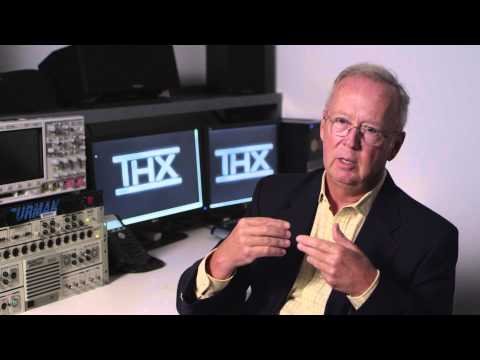

In [4]:
ipd.YouTubeVideo('6grjzBmHVTY', start=10, end=26)

Following the instructions in the score, here is a simpler version of the THX logo theme. It may not be exactly the same, but it comes close.

## Signal Model

For voice $i$, we have the following sinusoid with a time-dependent amplitude and frequency:

$$ x_i(t) = A(t) \sin(2 \pi f_i(t) t) $$

The output is a sum of the voices:

$$ y(t) = \sum_i x_i(t) = A(t) \sum_i \sin(2 \pi f_i(t) t) $$ 

In discrete time, for sampling rate/frequency $f_s$,

$$ y[n] = \sum_i x_i[n] = A[n] \sum_i \sin(2 \pi f_i[n] n/f_s) $$ 

## Stages

We define four stages in the signal:
1. During the `start`, voice frequencies move randomly within a narrow frequency range, and voices are quiet.
2. During the `transition`, voices move toward their target frequency, and voices become louder.
3. During the `sustain`, voices remain at their target frequency, and voices are loud.
4. During the `decay`, voices become quieter.

Here are the times when the `start`, `transition`, `sustain`, and `decay` stages begin. `t_end` is the end of the signal.

In [5]:
t_start = 0
t_transition = 4
t_sustain = 10
t_decay = 14
t_end = 16

Define a sample rate:

In [6]:
sr = 44100

Convert these times to units of samples:

In [7]:
n_start = t_start*sr
n_transition = t_transition*sr
n_sustain = t_sustain*sr
n_decay = t_decay*sr
n_end = t_end*sr

Define time axis in units of samples and seconds:

In [8]:
n = numpy.arange(n_end)
t = n/sr

## Amplitude

For each of the four stages above, define amplitude envelope, $A(t)$.

The `start` stage, `sustain` stage, and `end` will have constant amplitudes:

In [9]:
amplitude_start = 0.1
amplitude_sustain = 1
amplitude_end = 0.01

The `transition` and `decay` stages will increase or decrease following a geometric/exponential sequence:

In [10]:
amplitude_transition = numpy.geomspace(amplitude_start, amplitude_sustain, n_sustain-n_transition)
amplitude_decay = numpy.geomspace(amplitude_sustain, amplitude_end, n_end-n_decay)

Create the amplitude envelope:

In [11]:
amplitude = numpy.zeros(n_end)
amplitude[n_start:n_transition] = amplitude_start
amplitude[n_transition:n_sustain] = amplitude_transition
amplitude[n_sustain:n_decay] = amplitude_sustain
amplitude[n_decay:n_end] = amplitude_decay

Plot amplitude envelope with a log-y axis:

Text(0, 0.5, 'Amplitude Envelope')

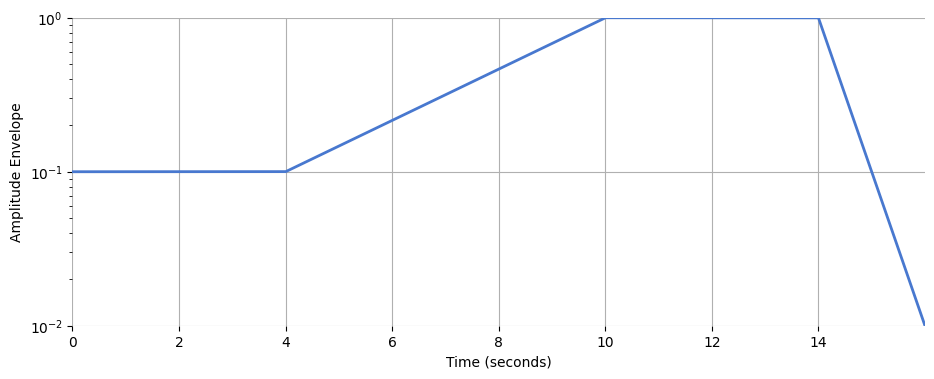

In [12]:
plt.figure(figsize=(11, 4))
plt.semilogy(t, amplitude, linewidth=2)
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude Envelope')

## Frequency

Revisiting the model above, for voice $i$,

$$ x_i[n] \propto \sin(2 \pi f_i[n] n/f_s) $$ 

Define $\phi_i[n] = f_i[n] n$. Therefore, $ x_i[n] \propto \sin((2 \pi/f_s) \phi_i[n] ) $.

Suppose $f_i$ remains constant over time. Then we have the following update rule:

$$ \phi[n] - \phi[n-1] = f_i n - f_i(n-1) = f_i $$

$$ \Rightarrow \phi[n] = \phi[n-1] + f_i $$

Now suppose $f_i[n]$ changes over time. Then we can simply use **the following update rule** instead:

$$ \phi[n] = \phi[n-1] + f_i[n] $$

This update rule is simply a cumulative sum of $f_i[n]$!

Let's define the frequencies during the final sustain phase, i.e. the final four measures. We tune the concert-A to be 448 Hz which seems to match the original recording. Then we simply define notes at A and D at different octaves. We use Pythagorean tuning, i.e. perfect fifths have a frequency ratio of 3:2, and octaves have a frequency ratio of 2:1.

In [13]:
f_sustain = [448*x for x in [1/12, 1/8, 1/6, 1/4, 1/3, 1/2, 2/3, 1, 4/3, 2, 8/3, 4, 16/3, 8]] * 3

Total number of voices:

In [14]:
num_voices = len(f_sustain)
num_voices

42

Then, we create our time-dependent frequecies for each voice.

In [15]:
fmin = librosa.note_to_hz('C0')
fmax = librosa.note_to_hz('C9')
n_bins = 9*12 # 9 octaves

(16.351597831287414, 8372.018089619156)

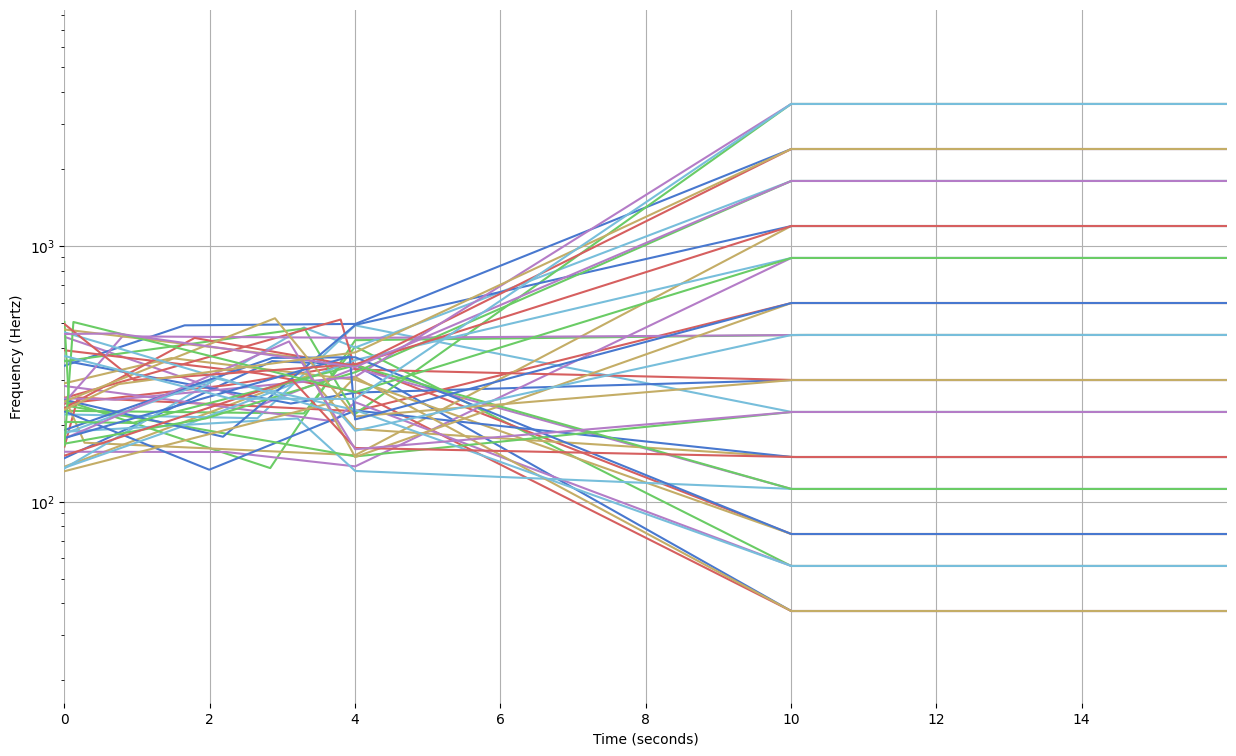

In [16]:
phi = [None]*num_voices
f_lo = librosa.note_to_hz('C3')
plt.figure(figsize=(15, 9))

for voice in range(num_voices):
    
    # Initialize frequency array.
    f = numpy.zeros(n_end)

    # Initial frequencies are random between C3 and C5.
    f1 = f_lo*4**numpy.random.rand()
    f2 = f_lo*4**numpy.random.rand()
    f_transition = f_lo*4**numpy.random.rand()

    # Define one random time point during the start stage.
    n1 = numpy.random.randint(n_start, n_transition)

    # Assign frequencies to each stage.
    f[n_start:n1] = numpy.geomspace(f1, f2, n1-n_start)
    f[n1:n_transition] = numpy.geomspace(f2, f_transition, n_transition-n1)
    f[n_transition:n_sustain] = numpy.geomspace(f_transition, f_sustain[voice], n_sustain-n_transition)
    f[n_sustain:n_end] = f_sustain[voice]
    
    # Perform the update rule. Easy!
    phi[voice] = numpy.cumsum(f)
    
    # Plot frequency.
    plt.semilogy(t, f)
    
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hertz)')
plt.ylim(fmin, fmax)

## Synthesize output

Initialize the output signal:

In [17]:
out_signal = numpy.zeros(n_end)

Finally, construct the output signal, one voice at a time:

In [18]:
for voice in range(num_voices):
    out_signal += numpy.sin(2*numpy.pi/sr*phi[voice])

Normalize the signal amplitude:

In [19]:
out_signal *= amplitude
out_signal *= (0.99/out_signal.max())

**Listen:**

In [20]:
ipd.Audio(out_signal, rate=sr)

Pretty cool!

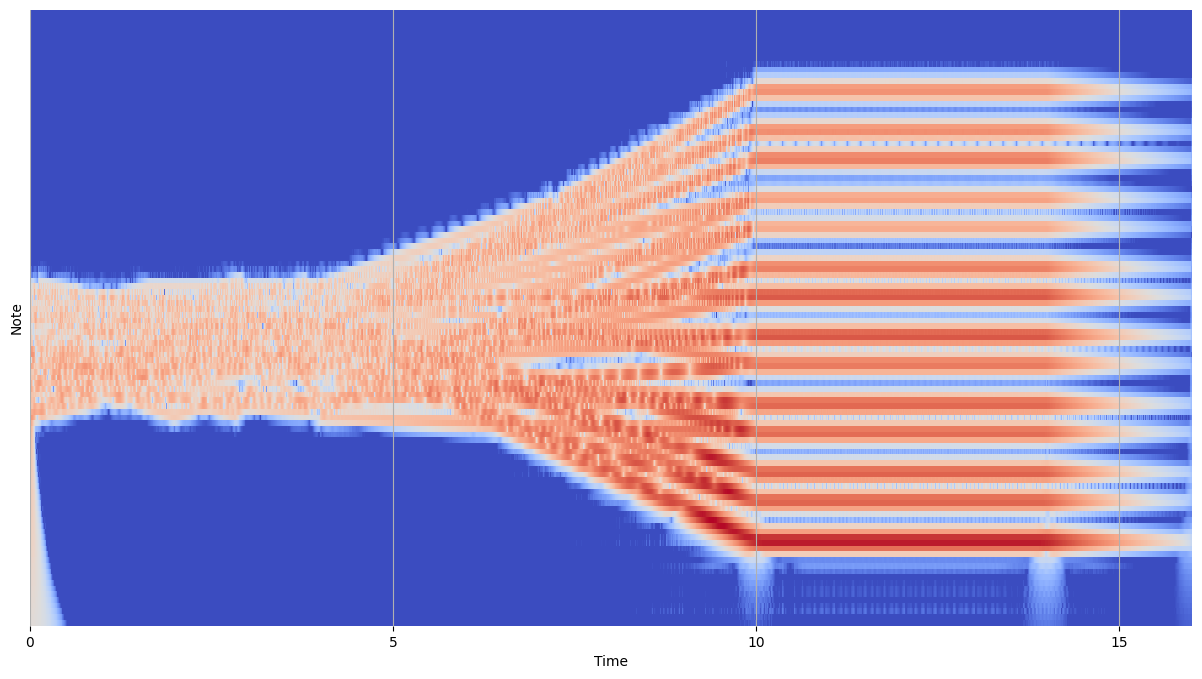

In [21]:
C = librosa.cqt(out_signal, sr=sr, 
                fmin=fmin, n_bins=n_bins)
C_db = librosa.amplitude_to_db(abs(C))
plt.figure(figsize=(15, 8))
librosa.display.specshow(C_db, sr=sr, x_axis='time', y_axis='cqt_note', 
                         fmin=fmin, cmap='coolwarm');

### How does it compare to the original?

In [22]:
thx, sr_thx = librosa.load('audio/thx_original.mp3')

In [23]:
ipd.Audio(thx, rate=sr_thx)

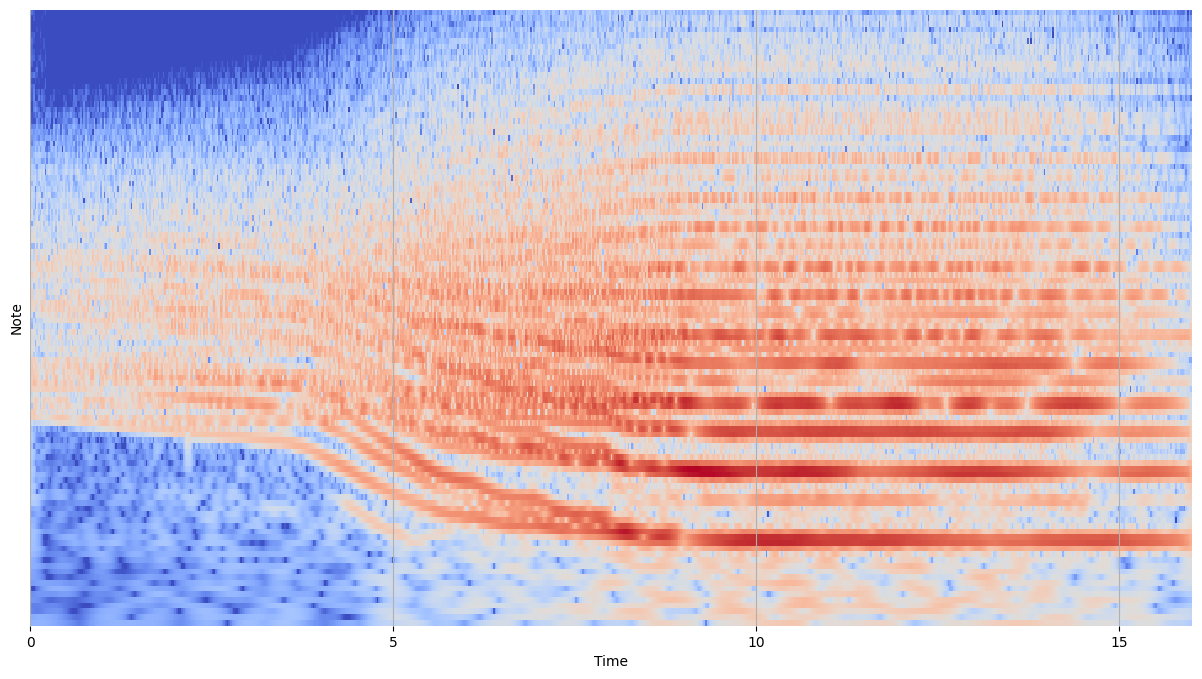

In [24]:
C = librosa.cqt(thx, sr=sr_thx, 
                fmin=fmin,
                n_bins=n_bins)

C_db = librosa.amplitude_to_db(abs(C))
plt.figure(figsize=(15, 8))
librosa.display.specshow(C_db, sr=sr_thx, x_axis='time', y_axis='cqt_note', fmin=fmin, cmap='coolwarm');